In [1]:
# code taken from https://machinelearningmastery.com/understanding-simple-recurrent-neural-networks-in-keras/

In [2]:
n = 9 # number of decimal places to keep

In [3]:
from pandas import read_csv
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
import matplotlib.pyplot as plt
import json

Epoch 1/20


2023-06-27 23:05:55.929536: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


187/187 - 1s - loss: 0.0495 - 603ms/epoch - 3ms/step
Epoch 2/20
187/187 - 0s - loss: 0.0348 - 169ms/epoch - 905us/step
Epoch 3/20
187/187 - 0s - loss: 0.0298 - 140ms/epoch - 747us/step
Epoch 4/20
187/187 - 0s - loss: 0.0260 - 134ms/epoch - 718us/step
Epoch 5/20
187/187 - 0s - loss: 0.0230 - 134ms/epoch - 718us/step
Epoch 6/20
187/187 - 0s - loss: 0.0205 - 134ms/epoch - 717us/step
Epoch 7/20
187/187 - 0s - loss: 0.0187 - 125ms/epoch - 670us/step
Epoch 8/20
187/187 - 0s - loss: 0.0168 - 288ms/epoch - 2ms/step
Epoch 9/20
187/187 - 0s - loss: 0.0157 - 283ms/epoch - 2ms/step
Epoch 10/20
187/187 - 0s - loss: 0.0141 - 131ms/epoch - 701us/step
Epoch 11/20
187/187 - 0s - loss: 0.0128 - 134ms/epoch - 718us/step
Epoch 12/20
187/187 - 0s - loss: 0.0118 - 130ms/epoch - 697us/step
Epoch 13/20
187/187 - 0s - loss: 0.0108 - 147ms/epoch - 786us/step
Epoch 14/20
187/187 - 0s - loss: 0.0100 - 138ms/epoch - 740us/step
Epoch 15/20
187/187 - 0s - loss: 0.0091 - 130ms/epoch - 696us/step
Epoch 16/20
187/187 -

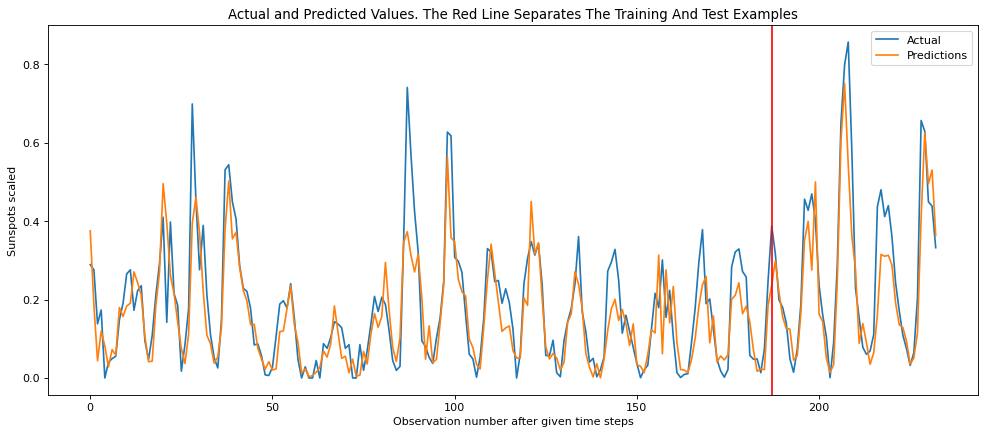

In [4]:
# Parameter split_percent defines the ratio of training examples
def get_train_test(url, split_percent=0.8):
    df = read_csv(url, usecols=[1], engine='python')
    data = np.array(df.values.astype('float32'))
    scaler = MinMaxScaler(feature_range=(0, 1))
    data = scaler.fit_transform(data).flatten()
    n = len(data)
    # Point for splitting data into train and test
    split = int(n*split_percent)
    train_data = data[range(split)]
    test_data = data[split:]
    return train_data, test_data, data

# Prepare the input X and target Y
def get_XY(dat, time_steps):
    Y_ind = np.arange(time_steps, len(dat), time_steps)
    Y = dat[Y_ind]
    rows_x = len(Y)
    X = dat[range(time_steps*rows_x)]
    X = np.reshape(X, (rows_x, time_steps, 1))    
    return X, Y

def create_RNN(hidden_units, dense_units, input_shape, activation):
    model = Sequential()
    model.add(SimpleRNN(hidden_units, input_shape=input_shape, activation=activation[0]))
    model.add(Dense(units=dense_units, activation=activation[1]))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

def print_error(trainY, testY, train_predict, test_predict):    
    # Error of predictions
    train_rmse = math.sqrt(mean_squared_error(trainY, train_predict))
    test_rmse = math.sqrt(mean_squared_error(testY, test_predict))
    # Print RMSE
    print('Train RMSE: %.3f RMSE' % (train_rmse))
    print('Test RMSE: %.3f RMSE' % (test_rmse))    

# Plot the result
def plot_result(trainY, testY, train_predict, test_predict):
    actual = np.append(trainY, testY)
    predictions = np.append(train_predict, test_predict)
    rows = len(actual)
    plt.figure(figsize=(15, 6), dpi=80)
    plt.plot(range(rows), actual)
    plt.plot(range(rows), predictions)
    plt.axvline(x=len(trainY), color='r')
    plt.legend(['Actual', 'Predictions'])
    plt.xlabel('Observation number after given time steps')
    plt.ylabel('Sunspots scaled')
    plt.title('Actual and Predicted Values. The Red Line Separates The Training And Test Examples')

sunspots_url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-sunspots.csv'
time_steps = 12
train_data, test_data, data = get_train_test(sunspots_url)
trainX, trainY = get_XY(train_data, time_steps)
testX, testY = get_XY(test_data, time_steps)

# Create model and train
model = create_RNN(hidden_units=3, dense_units=1, input_shape=(time_steps,1), 
                   activation=['linear', 'linear'])
model.fit(trainX, trainY, epochs=20, batch_size=1, verbose=2)

# make predictions
train_predict = model.predict(trainX)
test_predict = model.predict(testX)

# Print error
print_error(trainY, testY, train_predict, test_predict)

#Plot result
plot_result(trainY, testY, train_predict, test_predict)

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 3)                 15        
                                                                 
 dense (Dense)               (None, 1)                 4         
                                                                 
Total params: 19
Trainable params: 19
Non-trainable params: 0
_________________________________________________________________


In [6]:
wx = (model.get_weights()[0]*float(10**n)).round().astype(int)
wh = (model.get_weights()[1]*float(10**n)).round().astype(int)
bh = (model.get_weights()[2]*float(10**(2*n))).round().astype(int)
wy = (model.get_weights()[3]*float(10**n)).round().astype(int)
by = (model.get_weights()[4]*float(10**(2*n))).round().astype(int)

print('wx = ', wx, ' wh = ', wh, ' bh = ', bh, ' wy =', wy, 'by = ', by)

wx =  [[-153221616 1038880576 -428039936]]  wh =  [[-786596864 -437022048   51565892]
 [-409954688  509676576  751440384]
 [  79173920 -503383808  535765600]]  bh =  [ -496517982978048 -4313567457181696 66636078295023616]  wy = [[-725090944]
 [  53962872]
 [ 353362048]] by =  [8042243046768640]


In [7]:
X = (testX[0]*float(10**n)).round().astype(int)
print('X = ', X)

X =  [[522064576]
 [506304160]
 [330575264]
 [430654048]
 [459810816]
 [513396384]
 [571710016]
 [542553152]
 [396769088]
 [492119744]
 [293144192]
 [349881792]]


In [8]:
h = [np.zeros(3).astype(int)]
out = []
remainder = []
for i in range(12):
    H = np.dot(X[i], wx) + np.matmul(h[-1],wh) + bh
    print('H = ', H)
    o = H // 10**n
    r = H - o * (10**n)
    h.append(o)
    out.append(o.astype(str).flatten().tolist())
    remainder.append(r.astype(str).flatten().tolist())
    print('o = ', o, ' r = ', r)
o12 = np.dot(h[-1], wy) + by

with open('out.json', 'w') as f:
    json.dump(out , f)

with open('remainder.json', 'w') as f:
    json.dump(remainder , f)

H =  [ -80488095974052864  538049179966894080 -156828409403883520]
o =  [ -80488096  538049179 -156828410]  r =  [ 25947136 966894080 596116480]
H =  [-247754078955438016  910027007969071456  166055852084416960]
o =  [-247754079  910027007  166055852]  r =  [ 44561984 969071456  84416960]
H =  [-216187757542555392  827618270098267776  685159060139748932]
o =  [-216187758  827618270  685159060]  r =  [457444608  98267776 139748932]
H =  [-181468675733723264  614483044119621376  860141478060764232]
o =  [-181468676  614483044  860141478]  r =  [266276736 119621376  60764232]
H =  [-112016214825401152  432887091614885888  783042681484682544]
o =  [-112016215  432887091  783042681]  r =  [174598848 614885888 484682544]
H =  [-106515871899917920  404458923104734976  585921880601349956]
o =  [-106515872  404458923  585921880]  r =  [100082080 104734976 601349956]
H =  [-123729899170369920  547374299658181984  434272329686661248]
o =  [-123729900  547374299  434272329]  r =  [829630080 658181

In [9]:
y = model.predict(testX[[0]])
print(y, o12 / (10**(2*n)))

1/1 [==============================] - 0s 14ms/step
[[0.23670764]] [0.23670764]


In [10]:
# quantization
params_json = {
    'wx': wx.round().astype(int).astype(str).flatten().tolist(),
    'wh': wh.round().astype(int).astype(str).flatten().tolist(),
    'b': bh.round().astype(int).astype(str).flatten().tolist()
}

In [11]:
with open('params.json', 'w') as f:
    json.dump(params_json, f)

In [12]:
with open("in.json", "w") as f:
    json.dump(X.round().astype(int).astype(str).flatten().tolist(), f)